# Fitting of experimental chemical kinetics data
You perform some experiments in a batch reactor to determine the rate expression and thermochemistry for the reversible chemical reaction
$\require{mhchem}$
$$\ce{A <=> B}$$

Recall from thermodynamics that 
$\Delta G = \Delta H - T \Delta S$
and $\Delta G = R T \ln K_a$
where $K_a$ is the activity-based equilibrium constant of the chemical reaction, $R$ is the molar gas constant (8.314 J/mol/K) and $T$ is the temperature in Kelvin.

If we assume ideal solution (unit fugacity coefficients) then $K_a = K_c$ giving us the concentration-based equilibrium constant $K_c$. 
From kinetics you recall
$K_c = \frac{k_f}{k_r}$ 
where 
$k_f$ is the forward rate coefficient and $k_r$ is the reverse rate coefficient.
i.e. the rate of the reaction $\ce{A->B}$ is $k_f \times C_A$
and the reverse reaction $\ce{B->A}$ is $k_r \times C_B$
where $C_A$ and $C_B$ are the concentrations of species A and B respectively. 
In a batch reactor $\frac{dN_A}{dt} = r_{A(net)} V$, so (dividing through by the reactor volume $V$) $\frac{dC_A}{dt} = r_{A(net)}$ where $r_{A(net)}$ is the net rate of formation of species A, i.e. $r_{A(net)} = k_r C_B - k_f C_A$.
Assume the forward rate coefficient $k_f$ follows Arrhenius form, $k_f = A \exp\left(\frac{-E_A}{R T}\right)$ where $A$ is the "pre-exponential factor" and $E_A$ is the activation energy.

Fortunately, in this case you have good reason to believe that species A and B have very similar temperature-dependent heat capacities, so that $\Delta H_{rxn}$ and $\Delta S_{rxn}$ are independent of temperature.

You start the experiment with no B ($C_B=0$), and at time zero have some way to initiate the reaction, starting with a set concentration of $C_A$. 

You wish to determine the four paramaters:
$log_{10} A$,
$E_A$,
$\Delta H_{rxn}$,
$\Delta S_{rxn}$.

Based on a literature search, quantum chemistry calculations, and prior experience, your current estimates are as follows:
```
logA = 6.  # base-ten logarithm of A in s^-1
Ea = 45.   # Ea in kJ/mol
dH = -10.  # ∆H in kJ/mol
dS = -50.  # ∆S in J/mol/K
```


In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

import random
import SALib as sa
import SALib.sample
# from SALib.sample import morris as ms
# from SALib.analyze import morris as ma
# from SALib.plotting import morris as mp


In [2]:
# This cell just tries to make graphs look nicer
try:
    import seaborn as sns
except ImportError:
    # This block will be run if there's an ImportError, i.e you don't have seaborn installed.
    sns = False
    print ("If you want to try different figure formatting, "
           "type 'conda install seaborn' at an anaconda command prompt or terminal. "
           "See https://stanford.edu/~mwaskom/software/seaborn/ for details")
    # If not using seaborn, we can still control the size of the figures this way
    from pylab import rcParams
    rcParams['figure.figsize'] = 3, 3
else:
    # This block will be run if there is no ImportError
    sns.set_style("ticks")
    sns.set_context("paper",rc={"figure.figsize": (2, 2)})

We create a "named tuple" data type to store the exprimental data in.

In [3]:
from collections import namedtuple
ExperimentData = namedtuple('ExperimentData', ['T', 'cA_start', 'times', 'cA'])

def plot_experiment(e):
    """
    Plots the experimental data provided in 'e' 
    which should be of the type ExperimentData.
    """
    plt.plot(0, e.cA_start, 'ko')
    plt.plot(e.times, e.cA,':o', label="T={:.0f}K".format(e.T))
    plt.ylim(0,)
    plt.ylabel('$C_A$ (mol/L)')
    plt.xlabel('time (s)')
    plt.legend()

Now here are the data from your three experiments:

Experiment 0 was at T=298.15K and ran for 100 seconds
Experiment 1 was at T=308.15K and ran for 100 seconds
Experiment 2 was at T=323.15K and ran for 100 seconds


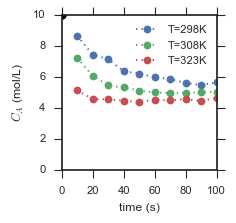

In [4]:
from numpy import array
experiments = [ExperimentData(T=298.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 8.649,  7.441,  7.141,  6.366,  6.215, 5.990, 5.852,  5.615,  5.481 ,  5.644])), 
               ExperimentData(T=308.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 7.230,  6.073,  5.452,  5.317,  5.121, 4.998,  4.951,  4.978,  5.015,  5.036])), 
               ExperimentData(T=323.15, 
                              cA_start=10.0, 
                              times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 
                              cA=array([ 5.137,  4.568,  4.548,  4.461,  4.382, 4.525,  4.483,  4.565,  4.459,  4.635])),
              ]

for i,e in enumerate(experiments):
    print("Experiment {} was at T={}K and ran for {} seconds".format(i, e.T, e.times[-1]))
    plot_experiment(e)

In [5]:
ParameterSet = namedtuple('ParameterSet', ['logA', 'Ea', 'dH', 'dS'])

# This is a sensible starting guess for your fitting
starting_guess = ParameterSet(
    logA = 6. , # base-ten logarithm of A in s^-1
    Ea = 45. , # Ea in kJ/mol
    dH = -10. , # ∆H in kJ/mol
    dS = -50.  # ∆S in J/mol/K
    )

# This should end up with your optimized parameters
optimized_parameters = ParameterSet(0,0,0,0)


# This should end up with your standard errors (one sigma)
# for the uncertainties in the fitted parameters.
# i.e. there should be a 68% chance the true value is 
# at least this close to your optimized parameter.
standard_errors = ParameterSet(0,0,0,0)


Ok, now insert some cells to determine the optimized_parameters and their standard_errors.

In [6]:
M = sum((len(e.times) for e in experiments))
print("In total will have M={} x_data entries".format(M))
print("each with k=2 values, T and t")
print("and M={} y_data entries, each being a concentration.".format(M))
x_data = np.zeros((2,M))
y_data = np.zeros(M)
i=0
for e in experiments:
    for time, cA in zip(e.times, e.cA):
        x_data[0,i] = e.T
        x_data[1,i] = time
        y_data[i] = cA
        i += 1
print('x_data = ',repr(x_data))
print('y_data = ',repr(y_data))

In total will have M=30 x_data entries
each with k=2 values, T and t
and M=30 y_data entries, each being a concentration.
x_data =  array([[ 298.15,  298.15,  298.15,  298.15,  298.15,  298.15,  298.15,
         298.15,  298.15,  298.15,  308.15,  308.15,  308.15,  308.15,
         308.15,  308.15,  308.15,  308.15,  308.15,  308.15,  323.15,
         323.15,  323.15,  323.15,  323.15,  323.15,  323.15,  323.15,
         323.15,  323.15],
       [  10.  ,   20.  ,   30.  ,   40.  ,   50.  ,   60.  ,   70.  ,
          80.  ,   90.  ,  100.  ,   10.  ,   20.  ,   30.  ,   40.  ,
          50.  ,   60.  ,   70.  ,   80.  ,   90.  ,  100.  ,   10.  ,
          20.  ,   30.  ,   40.  ,   50.  ,   60.  ,   70.  ,   80.  ,
          90.  ,  100.  ]])
y_data =  array([ 8.649,  7.441,  7.141,  6.366,  6.215,  5.99 ,  5.852,  5.615,
        5.481,  5.644,  7.23 ,  6.073,  5.452,  5.317,  5.121,  4.998,
        4.951,  4.978,  5.015,  5.036,  5.137,  4.568,  4.548,  4.461,
        4.382,  4.525,

In [7]:
cA_start = 10.
def my_model(x_data,
          logA,  # /s 
          Ea,  # kJ/mol
          dH, # kJ/mol
          dS,  # J/mol/K
         ):
    Ts, ts = x_data
    M = len(Ts) # number of data points
    y_data = np.zeros(M)
    for i in range(M):
        t = ts[i]
        T = Ts[i]
        R = 8.314 # J/mol/K
        kf = 10**logA * np.exp(-Ea*1e3 / (R * T))
        dG = dH*1e3 - T * dS # J/mol
        Ka = np.exp(-dG / (R * T))
        Kc = Ka # ideal solution, unit activity is 1 M
        kr = kf / Kc
        def dcAdt(cA, t):
            cB = cA_start - cA
            return kf * cB - kr * cA
        result = scipy.integrate.odeint(dcAdt, cA_start, [0,t])
        cA = result[-1,0]
        y_data[i] = cA
    return y_data
my_model(np.array([[298],[10]]), 7,50,-10,-40,)

array([ 7.12257881])

In [8]:
optimal_parameters, covariance = scipy.optimize.curve_fit(my_model,
                                                          x_data,
                                                          y_data,
                                                         p0=starting_guess,
                                                         method='trf')

print('fitted',optimal_parameters)
stdev = np.sqrt(np.diag(covariance))
print('+/-',stdev,'(one sigma)')

print(covariance)
optimized_parameters = ParameterSet(*optimal_parameters)
print(optimized_parameters)

standard_errors = ParameterSet(*stdev)
print(standard_errors)

fitted [  7.53752278  52.77627099 -11.5315229  -37.34953275]
+/- [ 0.43279535  2.54099874  0.79049444  2.51290283] (one sigma)
[[ 0.18731181  1.09920092  0.20901832  0.66698384]
 [ 1.09920092  6.45667462  1.25585698  4.00358094]
 [ 0.20901832  1.25585698  0.62488146  1.98556696]
 [ 0.66698384  4.00358094  1.98556696  6.31468064]]
ParameterSet(logA=7.5375227812900878, Ea=52.776270990593282, dH=-11.531522898616284, dS=-37.349532746201547)
ParameterSet(logA=0.43279534968837052, Ea=2.540998743700754, dH=0.79049443823588528, dS=2.512902831838947)


In [9]:
# Finish your notebook with this cell
print(starting_guess)
print(optimized_parameters)
print(standard_errors)

ParameterSet(logA=6.0, Ea=45.0, dH=-10.0, dS=-50.0)
ParameterSet(logA=7.5375227812900878, Ea=52.776270990593282, dH=-11.531522898616284, dS=-37.349532746201547)
ParameterSet(logA=0.43279534968837052, Ea=2.540998743700754, dH=0.79049443823588528, dS=2.512902831838947)


# Testing
This checks the output against the "true" values

In [10]:
true_params = ParameterSet(6.9, # logA in mol/L/s
                49., # Ea kJ/mol
                -13., # ∆H kJ/mol
                -42.# ∆S J/mol/K
                )
print("How many 'standard errors' from the true value was the optimized value?:")
discrepancy = (array(optimized_parameters) - array(true_params)) / array(standard_errors)
discrepancy = ParameterSet(*discrepancy)
for key,value in discrepancy._asdict().items():
    print(key,value)

How many 'standard errors' from the true value was the optimized value?:
logA 1.47303519261
Ea 1.48613650438
dH 1.85766911234
dS 1.85063552592


# The source data
This is how I generated the "experimental" data

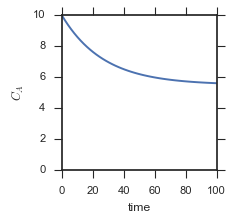

In [11]:
true_params = ParameterSet(6.9, # logA in mol/L/s
                49., # Ea kJ/mol
                -13., # ∆H kJ/mol
                -42.# ∆S J/mol/K
                )


def source_model(logA = true_params[0], # mol/L/s 
          Ea = true_params[1],  # kJ/mol
          dH = true_params[2],  # kJ/mol
          dS = true_params[3],  # J/mol/K
          T = 298.,   # K
          cA_start = 10., # mol/L
          end_time = 100., # s
          plot = False,
          times = None,
         ):
    
    R = 8.314 # J/mol/K
    kf = 10**logA * np.exp(-Ea*1e3 / (R * T))
    dG = dH*1e3 - T * dS # J/mol
    Ka = np.exp(-dG / (R * T))
    Kc = Ka # ideal solution, unit activity is 1 M
    kr = kf / Kc
    
    if times is None:
        times = np.linspace(0,end_time)
    assert times[0]==0, "Initial value problem needs to have t=0 at start"
    def dcAdt(cA, t):
        cB = cA_start - cA
        return kf * cB - kr * cA
    result = scipy.integrate.odeint(dcAdt, cA_start, times)
    result = result.T
    if plot:
        plt.plot(times, result[0])
        plt.ylim(0,)
        plt.ylabel('$C_A$')
        plt.xlabel('time')
    return times, result.T

times, result = source_model(plot=True)

In [12]:
def experiment(cA_start, T, measure_times,
              T_stdev = 1.,
              time_stdev = 0.5,
              time_offset_stdev = 1.0,
              measurement_stdev = 0.1):
    
    # T_stdev = time_stdev = time_offset_stdev = measurement_stdev = 1e-8 # turn off errors

    # Just for the plot
    times,values = source_model(cA_start = cA_start,
                        T = T,
                        plot = True)
    
    offset = np.random.normal(scale=time_offset_stdev)
    
    time_errors = np.random.normal(scale=time_stdev, size=measure_times.shape)
    ode_times = np.append([0],measure_times + time_errors + offset)
    times,values = source_model(cA_start = cA_start,
                         T = T + np.random.normal(scale=T_stdev),
                        times = ode_times)
    measured_times = times[1:]
    measured_values = values[1:,0]
    #print(measured_values)
    measured_values += np.random.normal(scale=measurement_stdev, size=measured_values.shape)
    plt.plot(measure_times,measured_values,'ro')
    plt.title("T={:.0f}K".format(T))
    return ExperimentData(
        T = T,
        cA_start = cA_start,
        times = measure_times,
        cA = measured_values
        )

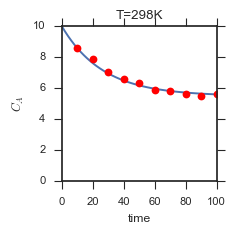

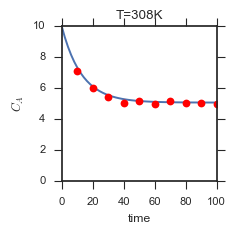

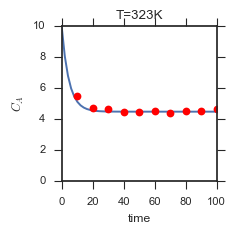

In [13]:
# This will be different each time you run it, as I didn't seed the random number generator
e1 = experiment(10., 273.15+25, np.arange(10,110,10))
plt.show()
e2 = experiment(10., 273.15+35, np.arange(10,110,10))
plt.show()
e3 = experiment(10., 273.15+50, np.arange(10,110,10))
plt.show()

experiments = [e1, e2, e3]

experiments = [ExperimentData(T=298.15, cA_start=10.0, times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), cA=array([ 8.59192688,  7.8925884 ,  7.04407964,  6.60250971,  6.31554902,
        5.85211105,  5.82697177,  5.60859228,  5.48644599,  5.58135441])), ExperimentData(T=308.15, cA_start=10.0, times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), cA=array([ 7.08539494,  5.97471819,  5.38627088,  5.00473262,  5.15927423,
        4.98440261,  5.16327922,  5.02361014,  5.0045287 ,  4.97931548])), ExperimentData(T=323.15, cA_start=10.0, times=array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), cA=array([ 5.46155862,  4.7184106 ,  4.65472987,  4.46524618,  4.47203969,
        4.50621219,  4.41005526,  4.51969896,  4.48765806,  4.61134396]))]


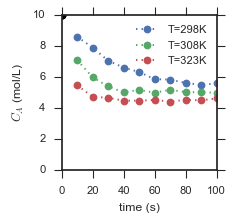

In [14]:
for e in experiments:
    plot_experiment(e)
print('experiments =',repr(experiments))